# Importing files

In [60]:
import pandas as pd

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer # for 3.2

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.utils import resample

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer # 3.4
from sklearn.decomposition import LatentDirichletAllocation # 4.1

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical

from collections import Counter

from wordcloud import WordCloud

import gensim
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc

# Q1

## 1.1.       Load the data frame into Python, and increase the size of the dataset by separating each of the 50 posts in the posts column of each row into its own row. 

In [72]:
df = pd.read_csv(r"C:\Users\Shivan\OneDrive\Desktop\ITNPA\Project\Q1\mbti_datasets.csv")

# Step 2: Split the 'posts' column by '|||'
df['posts'] = df['posts'].apply(lambda x: x.split('|||'))

# Step 3: Explode the 'posts' column to get each post in its own row
df = df.explode('posts').reset_index(drop=True)

In [14]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


## 1.2.       Remove all web urls, punctuation marks, and extra spacing and make every post lowercase.	

In [74]:
# Function to clean a single post
def clean_post(post):
    # Remove URLs
    post = re.sub(r'http\S+|www\S+|https\S+', '', post, flags=re.MULTILINE)
    
    # Remove punctuation
    post = re.sub(r'[^\w\s]', '', post)
    
    # Remove extra spaces
    post = re.sub(r'\s+', ' ', post).strip()
    
    # Convert to lowercase
    post = post.lower()
    
    return post


df['posts'] = df['posts'].apply(lambda x: clean_post(x))

In [23]:
df.head()

,type,posts
0,INFJ,
1,INFJ,
2,INFJ,enfp and intj moments sportscenter not top ten...
3,INFJ,what has been the most lifechanging experience...
4,INFJ,on repeat for most of today


In [76]:
df = df[df['posts'].str.strip() != '']

# Reset the index 
df = df.reset_index(drop=True)

In [27]:
df.head()

,type,posts
0,INFJ,enfp and intj moments sportscenter not top ten...
1,INFJ,what has been the most lifechanging experience...
2,INFJ,on repeat for most of today
3,INFJ,may the perc experience immerse you
4,INFJ,the last thing my infj friend posted on his fa...


## 1.3.       Tokenise each post and store the tokens in an additional column called “tokens”. Ensure that stop words are removed.	

In [78]:
# tokenize words
df['posts'] = df['posts'].apply(lambda x: word_tokenize(x))

In [39]:
df.head()

,type,posts
0,INFJ,"[enfp, and, intj, moments, sportscenter, not, ..."
1,INFJ,"[what, has, been, the, most, lifechanging, exp..."
2,INFJ,"[on, repeat, for, most, of, today]"
3,INFJ,"[may, the, perc, experience, immerse, you]"
4,INFJ,"[the, last, thing, my, infj, friend, posted, o..."


In [84]:
stop_words = set(stopwords.words('english'))

# remove stopwords
df['posts'] = df['posts'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])


In [86]:
df.head()

,type,posts
0,INFJ,"[enfp, intj, moments, sportscenter, top, ten, ..."
1,INFJ,"[lifechanging, experience, life]"
2,INFJ,"[repeat, today]"
3,INFJ,"[may, perc, experience, immerse]"
4,INFJ,"[last, thing, infj, friend, posted, facebook, ..."


## 1.4.       Provide a count plot of all records per personality type in the datasets. 

C:\Users\Shivan\AppData\Local\Temp\ipykernel_9636\4191868971.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='viridis')


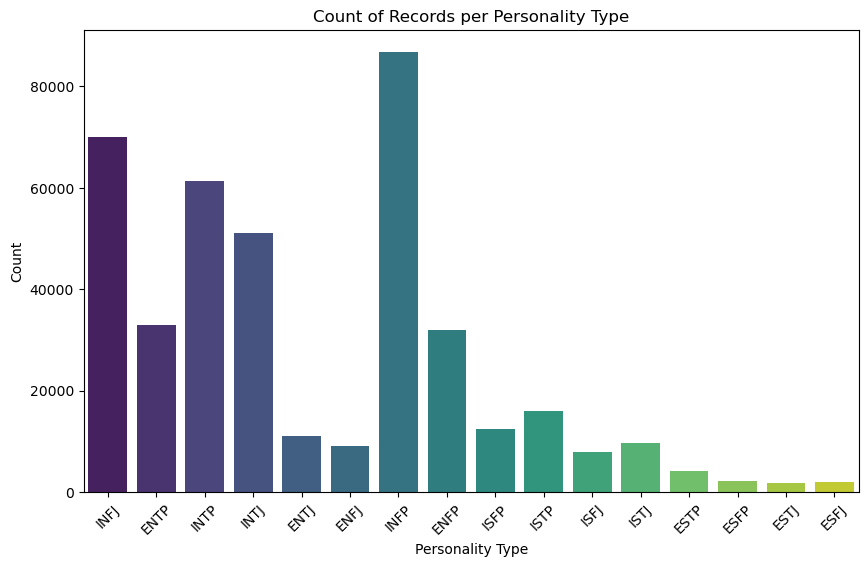

In [50]:
plt.figure(figsize=(10, 6))  # Set figure size

# Create a count plot for the 'Type' column
sns.countplot(x='type', data=df, palette='viridis')

plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.title('Count of Records per Personality Type')

plt.xticks(rotation=45)

plt.show()

# Q2

## 2.1 Balance your dataset by upsampling and downsampling to roughly half the size of the largest class size.

In [58]:
# Determine the size of each class
class_sizes = df['type'].value_counts()

# Calculate the target size for each class (half of the largest class)
max_size = class_sizes.max()
target_size = max_size // 2  # Half the size of the largest class

# Split the data into majority and minority classes
df_balanced = pd.DataFrame()  # Initialize an empty DataFrame for the balanced dataset

# Loop through each class and balance the class
for class_type, class_count in class_sizes.items():
    class_data = df[df['type'] == class_type]
    
    if class_count > target_size:
        # Downsample majority class to the target size
        class_data_resampled = resample(class_data, 
                                        replace=False,   # Sample without replacement
                                        n_samples=target_size,  # Target number of samples
                                        random_state=42)
    else:
        # Upsample minority class to the target size
        class_data_resampled = resample(class_data, 
                                        replace=True,    # Sample with replacement
                                        n_samples=target_size,  # Target number of samples
                                        random_state=42)
    
    # Append resampled data to the balanced dataset
    df_balanced = pd.concat([df_balanced, class_data_resampled])

# Reset index after balancing
df_balanced = df_balanced.reset_index(drop=True)

# Check the class distribution after balancing
print(df_balanced['type'].value_counts())

type
INFP    43375
INFJ    43375
INTP    43375
INTJ    43375
ENTP    43375
ENFP    43375
ISTP    43375
ISFP    43375
ENTJ    43375
ISTJ    43375
ENFJ    43375
ISFJ    43375
ESTP    43375
ESFP    43375
ESFJ    43375
ESTJ    43375
Name: count, dtype: int64


## 2.2. Provide a count plot of all records per personality type in the datasets after resampling                                                                                                                            

C:\Users\Shivan\AppData\Local\Temp\ipykernel_9636\4118843728.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df_balanced, palette='viridis')


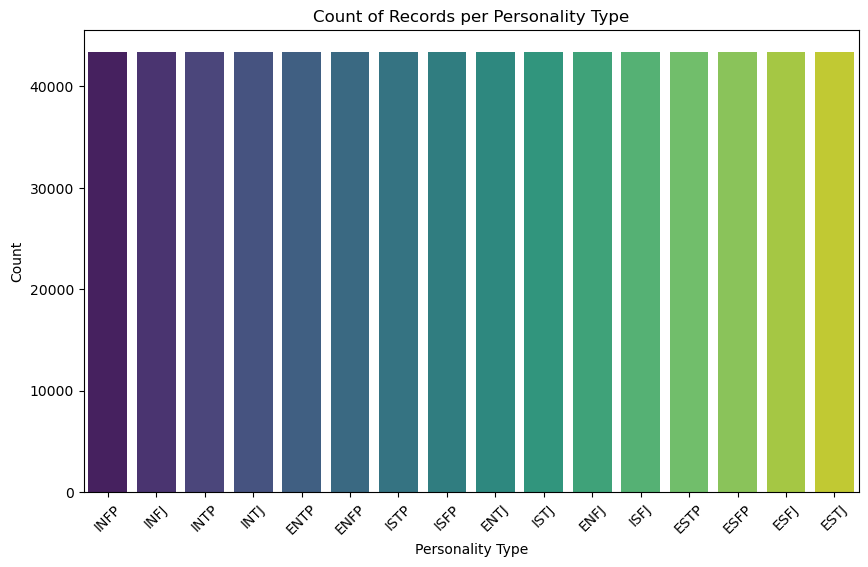

In [61]:
plt.figure(figsize=(10, 6))  # Set figure size

# Create a count plot for the 'Type' column
sns.countplot(x='type', data=df_balanced, palette='viridis')

plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.title('Count of Records per Personality Type')

plt.xticks(rotation=45)

plt.show()

 ## 2.3. Using a CountVectorizer, generate a feature set from the top 50 words in the data records. Ensure that stop words are not included and characters are in lower case and generate a machine learning data frame from your results.	

In [88]:
df.head()

,type,posts
0,INFJ,"[enfp, intj, moments, sportscenter, top, ten, ..."
1,INFJ,"[lifechanging, experience, life]"
2,INFJ,"[repeat, today]"
3,INFJ,"[may, perc, experience, immerse]"
4,INFJ,"[last, thing, infj, friend, posted, facebook, ..."


In [92]:
df2 = df.copy()

# Join the tokenized words back into full posts (strings)
df2['posts'] =df2['posts'].apply(lambda tokens: ' '.join(tokens))

#  Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50, lowercase=True)

# Fit the vectorizer to the posts and transform the text data into feature vectors
X = vectorizer.fit_transform(df2['posts'])

# Create a DataFrame with the features (top 50 words)
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Add the 'Type' column (target variable) to the DataFrame for machine learning
df_ml = pd.concat([df_features, df2['type'].reset_index(drop=True)], axis=1)

# Display the first few rows of the machine learning DataFrame
print(df_ml.head())


   actually  best  didnt  dont  feel  friend  friends  going  good  got  ...  \
0         0     0      0     0     0       0        0      0     0    0  ...   
1         0     0      0     0     0       0        0      0     0    0  ...   
2         0     0      0     0     0       0        0      0     0    0  ...   
3         0     0      0     0     0       0        0      0     0    0  ...   
4         0     0      0     0     0       1        0      0     0    0  ...   

   thread  time  try  type  want  way  work  yes  youre  type  
0       0     0    0     0     0    0     0    0      0  INFJ  
1       0     0    0     0     0    0     0    0      0  INFJ  
2       0     0    0     0     0    0     0    0      0  INFJ  
3       0     0    0     0     0    0     0    0      0  INFJ  
4       0     0    0     0     0    0     0    0      0  INFJ  

[5 rows x 51 columns]


## 2.4. Split your dataset into Training/Test sets with a proportion of 80/20.  You may use a random_state of 1234 for reproducibility.

In [99]:
df.head()

,type,posts
0,INFJ,"[enfp, intj, moments, sportscenter, top, ten, ..."
1,INFJ,"[lifechanging, experience, life]"
2,INFJ,"[repeat, today]"
3,INFJ,"[may, perc, experience, immerse]"
4,INFJ,"[last, thing, infj, friend, posted, facebook, ..."


In [107]:
# Note: X is define above

y = df['type']  
y = pd.get_dummies(y) 

# Convert boolean to integers
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## 2.5.      Train your model using a model of your choice, preferably (Deep) Feedforward Neural networks using the most appropriate configuration and hyperparameter tuning.   

In [113]:
model = Sequential()

# Input layer (using Input(shape=...)) and first hidden layer
model.add(Input(shape=(X_train.shape[1],)))  # Input shape is the number of features
model.add(Dense(64, activation='relu'))  # 64 neurons

# Second hidden layer
model.add(Dense(32, activation='relu'))  # 32 neurons

# Output layer (number of neurons = number of classes)
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train.toarray(), y_train, epochs=50, batch_size=32, validation_data=(X_test.toarray(), y_test), verbose=2)


Epoch 1/50
10259/10259 - 41s - 4ms/step - accuracy: 0.2314 - loss: 2.2537 - val_accuracy: 0.2303 - val_loss: 2.2501
Epoch 2/50
10259/10259 - 23s - 2ms/step - accuracy: 0.2343 - loss: 2.2440 - val_accuracy: 0.2300 - val_loss: 2.2499
Epoch 3/50
10259/10259 - 25s - 2ms/step - accuracy: 0.2342 - loss: 2.2421 - val_accuracy: 0.2305 - val_loss: 2.2492
Epoch 4/50
10259/10259 - 24s - 2ms/step - accuracy: 0.2349 - loss: 2.2406 - val_accuracy: 0.2286 - val_loss: 2.2488
Epoch 5/50
10259/10259 - 28s - 3ms/step - accuracy: 0.2354 - loss: 2.2394 - val_accuracy: 0.2285 - val_loss: 2.2482
Epoch 6/50
10259/10259 - 28s - 3ms/step - accuracy: 0.2352 - loss: 2.2384 - val_accuracy: 0.2299 - val_loss: 2.2488
Epoch 7/50
10259/10259 - 40s - 4ms/step - accuracy: 0.2356 - loss: 2.2376 - val_accuracy: 0.2302 - val_loss: 2.2493
Epoch 8/50
10259/10259 - 28s - 3ms/step - accuracy: 0.2357 - loss: 2.2369 - val_accuracy: 0.2298 - val_loss: 2.2490
Epoch 9/50
10259/10259 - 41s - 4ms/step - accuracy: 0.2362 - loss: 2.236

## 2.6.      Compute your classification report on both the training and test set (precision, recall, f1-score, support).	

In [116]:
# Evaluate and generate classification report
# Predictions on training and test sets
y_train_pred = model.predict(X_train.toarray())
y_test_pred = model.predict(X_test.toarray())

# Convert one-hot encoded predictions back to class labels
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_test_pred_classes = y_test_pred.argmax(axis=1)

# Convert one-hot encoded actual labels back to class labels
y_train_actual = y_train.values.argmax(axis=1)
y_test_actual = y_test.values.argmax(axis=1)


10259/10259 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step
2565/2565 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


In [120]:
# Classification report for training set
print("Training Set Classification Report:")
print(classification_report(y_train_actual, y_train_pred_classes, zero_division=0))

# Classification report for test set
print("Test Set Classification Report:")
print(classification_report(y_test_actual, y_test_pred_classes, zero_division=0))


Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7324
           1       0.29      0.00      0.00     25667
           2       0.00      0.00      0.00      8835
           3       0.50      0.00      0.00     26390
           4       0.00      0.00      0.00      1573
           5       0.00      0.00      0.00      1723
           6       0.00      0.00      0.00      1511
           7       0.00      0.00      0.00      3315
           8       0.34      0.13      0.19     55985
           9       0.23      0.90      0.36     69671
          10       0.41      0.07      0.13     40621
          11       0.29      0.11      0.16     49042
          12       0.25      0.00      0.00      6277
          13       0.46      0.00      0.01      9906
          14       0.00      0.00      0.00      7730
          15       0.00      0.00      0.00     12696

    accuracy                           0.24 

# Q3

## 3.1.       Load the datasets in a pandas data frame, tokenise every article into a tokens column and remove stop words.

In [9]:
df = pd.read_csv(r"C:\Users\Shivan\OneDrive\Desktop\ITNPA\Project\Q3\articles_dataset.csv")


In [6]:
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [40]:
# tokenize words
df['headline_text'] = df['headline_text'].apply(lambda x: word_tokenize(x))

In [42]:
stop_words = set(stopwords.words('english'))

# remove stopwords
df['headline_text'] = df['headline_text'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])


## 3.2.       Provide a kernel density function of the sentiment distribution across news articles. You may use an inbuilt Sentiment Analyser.

In [56]:

# Join tokens into a single string for sentiment analysis
df['text'] = df['headline_text'].apply(lambda tokens: ' '.join(tokens))

# Compute sentiment scores using VADER
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# VADER returns a 'compound' sentiment score between -1 (negative) and 1 (positive)


In [62]:
df.head()

,publish_date,headline_text,text,sentiment
0,20030219,"[aba, decides, community, broadcasting, licence]",aba decides community broadcasting licence,0.0000
1,20030219,"[act, fire, witnesses, must, aware, defamation]",act fire witnesses must aware defamation,-0.3400
2,20030219,"[g, calls, infrastructure, protection, summit]",g calls infrastructure protection summit,0.0000
3,20030219,"[air, nz, staff, aust, strike, pay, rise]",air nz staff aust strike pay rise,-0.2263
4,20030219,"[air, nz, strike, affect, australian, travellers]",air nz strike affect australian travellers,-0.1280


C:\Users\Shivan\AppData\Local\Temp\ipykernel_1784\600503544.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment'], shade=True, color='blue')


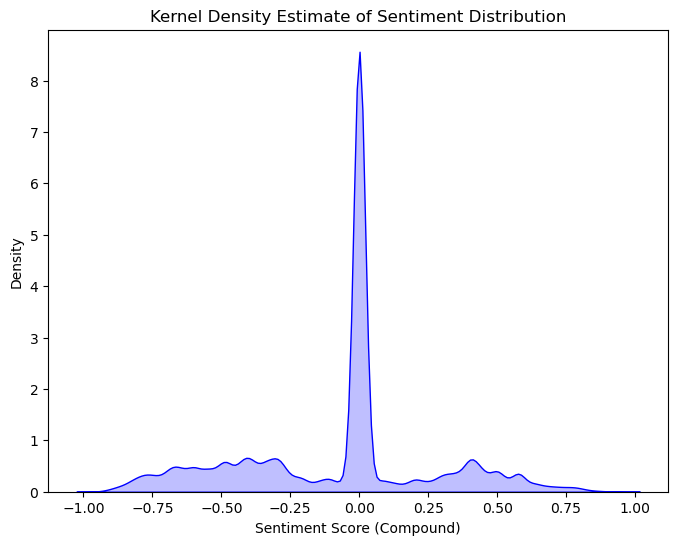

In [18]:
# Plot KDE of sentiment scores
plt.figure(figsize=(8, 6))
sns.kdeplot(df['sentiment'], shade=True, color='blue')
plt.title('Kernel Density Estimate of Sentiment Distribution')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Density')
plt.show()

## 3.3.       Aggregate all news data into a single data structure and provide a Term Frequency in descending order of frequent words. Display the top 20 words on the bar plot.	

In [64]:
# Flatten all tokens from each row in 'headline_text' into one list
all_headlines = [word for tokens in df['headline_text'] for word in tokens]

# Count the frequency of each unique word
word_counts = Counter(all_headlines)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Separate words and their counts for plotting
words, counts = zip(*top_20_words)

C:\Users\Shivan\AppData\Local\Temp\ipykernel_1784\2487655586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="plasma")


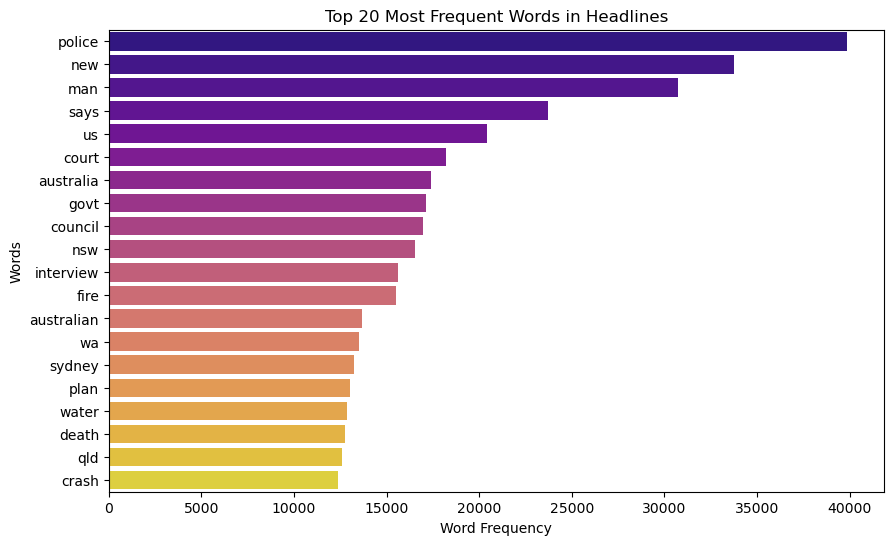

In [66]:
# Create a bar plot for the top 20 most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette="plasma")
plt.title('Top 20 Most Frequent Words in Headlines')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.show()


## 3.4.       Using a corpus of news articles (‘articles_corpus.zip’), generate a Term document inverse document Frequency (TFIDF) from 3.3 and provide a bar plot of the top 20 Words including a Wordcloud.	

In [11]:
import os

# Specify the directory where the articles are stored
directory = r'C:\Users\Shivan\OneDrive\Desktop\ITNPA\Project\Q3\news_corpus\news_corpus'  # Change this to your folder's path

# Initialize an empty list to store the contents of all articles
articles = []

# Loop through all files in the directory
for file_name in os.listdir(directory):
    # Check if the file is a text file
    if file_name.endswith('.txt'):
        file_path = os.path.join(directory, file_name)
        
        # Open the file and read its contents
        with open(file_path, 'r', encoding='utf-8') as file:
            article_content = file.read()
            
            # Append the content of each article to the list
            articles.append(article_content)

# Now the 'articles' list contains the content of all the text files
print(f"Total articles loaded: {len(articles)}")


Total articles loaded: 10


In [19]:
#  Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

# Fit and transform the list of articles to compute TF-IDF scores
X_tfidf = vectorizer.fit_transform(articles)

# Get the feature names (words)
tfidf_feature_names = vectorizer.get_feature_names_out()

# Sum up the TF-IDF scores for each word across all documents
tfidf_scores = X_tfidf.sum(axis=0).A1  # Convert the matrix to an array

# Create a dictionary of words and their summed TF-IDF scores
word_tfidf = dict(zip(tfidf_feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_word_tfidf = sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 words with the highest TF-IDF scores
top_20_words = sorted_word_tfidf[:20]
words, scores = zip(*top_20_words)


C:\Users\Shivan\AppData\Local\Temp\ipykernel_1784\3644130778.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(words), palette='coolwarm')


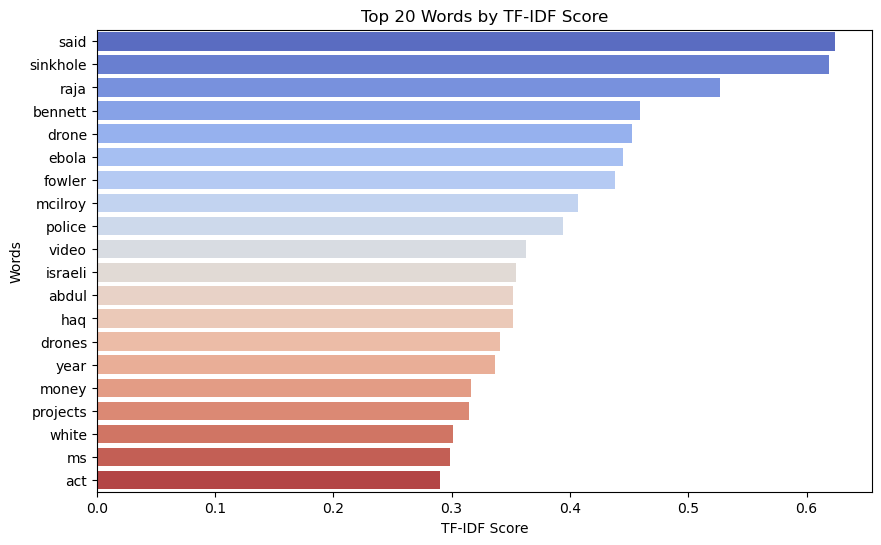

In [76]:
# bar plot for the top 20 words by TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x=list(scores), y=list(words), palette='coolwarm')
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()


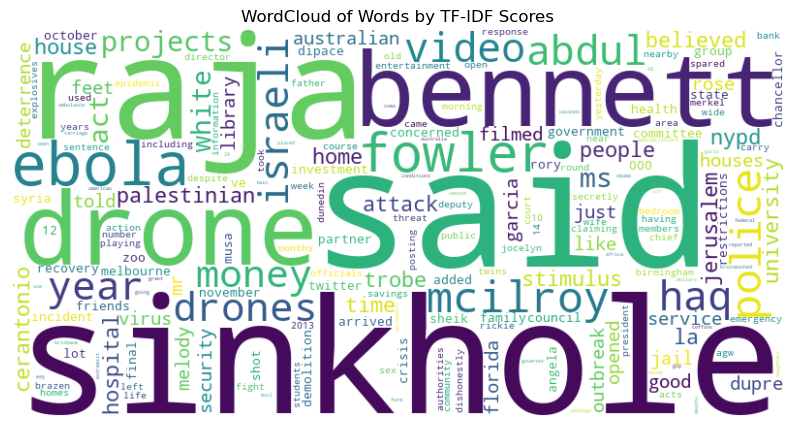

In [80]:
#  Generate a WordCloud from the TF-IDF scores
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(word_tfidf)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('WordCloud of Words by TF-IDF Scores')
plt.show()


# Q4

## 4.1.  Using Latent Dirichlet Allocation (LDA), find the top 4 topics in the documents and display the topics list of words and distribution.	

In [21]:
# Initialize the Count Vectorizer
vectorizer = CountVectorizer(stop_words='english', lowercase=True)

# Fit and transform the list of articles
X_counts = vectorizer.fit_transform(articles)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

print(f"Number of unique words: {len(feature_names)}")


Number of unique words: 1824


In [23]:
#Initialize LDA with 4 topics
lda_model = LatentDirichletAllocation(n_components=4, random_state=1234)

# Fit the LDA model on the document-term matrix
lda_model.fit(X_counts)

# Get the components (topics)
topics = lda_model.components_

# Display the top words for each topic
n_top_words = 10  # Number of top words per topic

for topic_idx, topic in enumerate(topics):
    print(f"\nTopic #{topic_idx + 1}:")
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Top words: ", ", ".join(top_words))



Topic #1:
Top words:  drone, haq, abdul, drones, year, believed, cerantonio, nypd, australian, police

Topic #2:
Top words:  bennett, sinkhole, ms, melody, service, rose, said, mr, family, home

Topic #3:
Top words:  raja, said, israeli, palestinian, attack, jerusalem, houses, security, deterrence, jail

Topic #4:
Top words:  said, fowler, mcilroy, ebola, projects, garcia, lot, stimulus, outbreak, virus


In [35]:
# Get topic distribution for each document
doc_topic_distribution = lda_model.transform(X_counts)

# Display the topic distribution for the first few documents
for i, doc_dist in enumerate(doc_topic_distribution[:5]):  # First 5 documents
    print(f"Document {i+1} topic distribution: {doc_dist}")


Document 1 topic distribution: [9.97056225e-01 9.85523020e-04 9.79127094e-04 9.79124981e-04]
Document 2 topic distribution: [0.00182508 0.99461284 0.00178027 0.00178181]
Document 3 topic distribution: [5.52500615e-04 5.54062596e-04 5.51929003e-04 9.98341508e-01]
Document 4 topic distribution: [7.49406010e-04 7.47671085e-04 7.47507762e-04 9.97755415e-01]
Document 5 topic distribution: [8.17454109e-04 9.97543694e-01 8.17763516e-04 8.21088166e-04]


## 4.2.  Provide a Word cloud of the top keywords in each topic.	

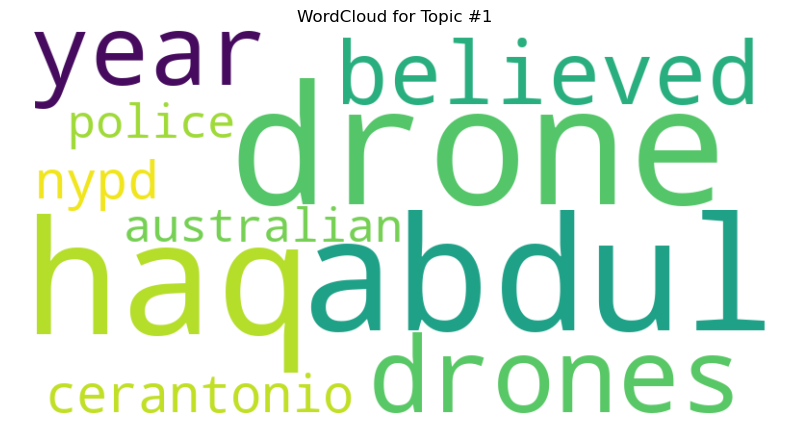

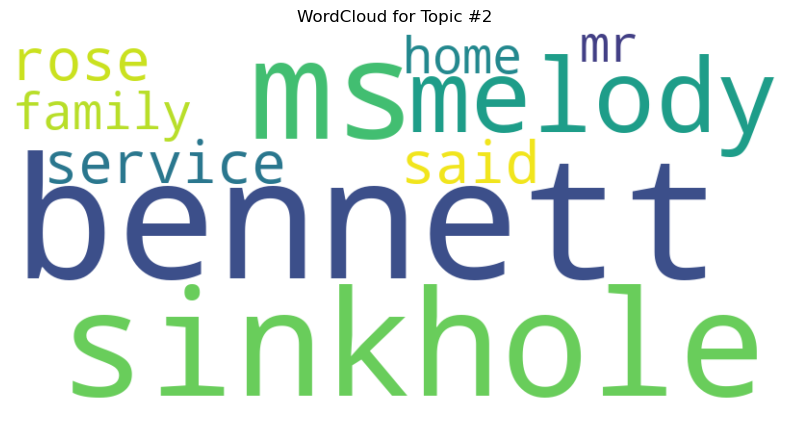

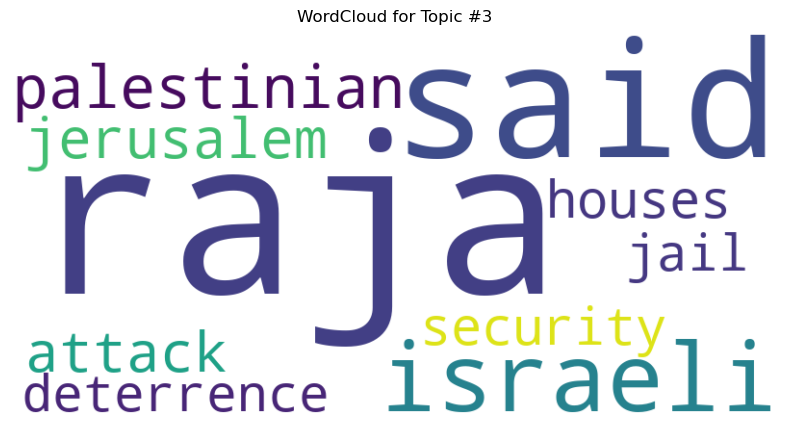

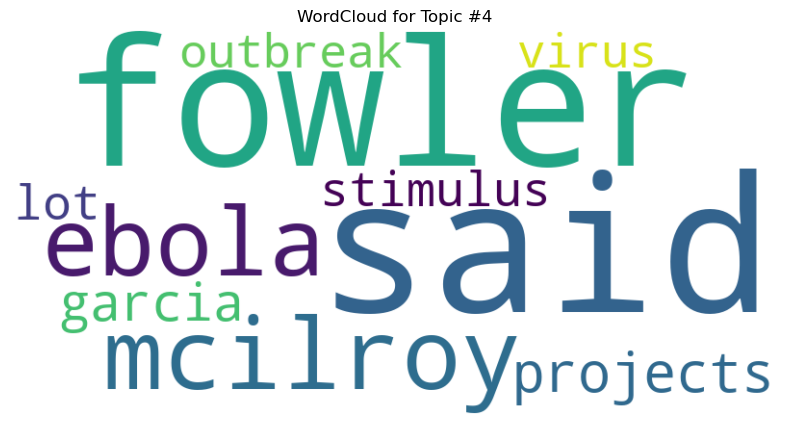

In [44]:
# Step 8: Generate and plot WordClouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}  # Top words with frequencies

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    
    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Topic #{topic_idx + 1}")
    plt.show()

## 4.3.   Using a package like pyLDAvis, provide an Intertopic Distance Map including the most salient words per topic.	

In [62]:
# Tokenize articles
tokenized_articles = [article.split() for article in articles]

# Create a dictionary and corpus for gensim
dictionary = Dictionary(tokenized_articles)
corpus = [dictionary.doc2bow(article) for article in tokenized_articles]

# Train LDA model with gensim
lda_model = LdaModel(corpus=corpus, num_topics=4, id2word=dictionary, passes=20, random_state=1234)

# Prepare the visualization with pyLDAvis
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)  